# To note:
### The code file uses the simple all-or-nothing (AON) assignment and all the code is available for it to execute successfully. However, please note that the performance metrics outputs are based on the non-realistic AON assignment. If you already have the solution of tutorial 3 please use the other file 'network_performance_analysis.ipynb'

In [2]:
# libraries
import pandas as pd
import os
import networkx as nx
import math
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
# import contextily as cx

# local functions
from utils import import_matrix

pd.options.mode.chained_assignment = None 

# Manila case study

## Loading model data

In [3]:
root    = './'
city    = 'Manila'

In [4]:
#-------------------- Network --------------------

# Importing the networks into a Pandas dataframe consists of a single line of code
# but we can also make sure all headers are lower case and without trailing spaces

netfile = os.path.join(root, city, 'net.csv')
network = pd.read_csv(netfile)#, header=7)

trimmed= [s.strip().lower() for s in network.columns]
network.columns = trimmed
    

In [5]:
#-------------------- Network attributes --------------------

linkindexordering = list(zip(network['from'], network['to']))
edge_attr = {}
mlt = False
for row in network.itertuples():
    edge_attr[(row[1], row[2])] = {'capacity':row[3], 'length':row[4], 'FFT':row[5], 'alpha':row[6],
                                    'beta':row[7], 'type':row[10], 'flow':0, 'cost':row[5], 'Oflow':None}
    
edge = [(row[1], row[2]) for row in network.itertuples()]

In [6]:
#-------------------- Graph --------------------

NetGraph = nx.DiGraph()
NetGraph.add_edges_from(edge)
nx.set_edge_attributes(NetGraph, edge_attr)

In [7]:
demandfile = os.path.join(root, city, 'ODDemand.csv')
odDemands = pd.read_csv(demandfile, header=0)
ODdemand = {(int(row['Origin']), int(row['Destination'])):int(row['Demand']) for index, row in odDemands.iterrows()}

In [8]:
#-------------------- Zone centroids --------------------

centroidspath = os.path.join(root, city, 'centroid.csv')
centroids = pd.read_csv(centroidspath, header=0)

if 'fishnetID' in centroids.columns:
    centroids.rename(columns={'fishnetID': 'ZoneID'}, inplace=True)

zone2cent = {zone: [row['osmid'] for index, row in centroids[centroids['ZoneID'] == zone].iterrows()] for zone in centroids['ZoneID']}


## All or nothing assignment

In [9]:
def AONloading(G, zone2cent, Demand, computesptt = False):
    '''
    Input:
    G: a directed graph object, which represents a road network.
    zone2cent: a dictionary with zones as keys and cetroids in zone as a list of ints
    zones: a list of zones
    Demand: a dictonary of demand values for each origin-destination pair in the graph.
    Process:
    It computes the SPTT by running the Dijkstra's shortest path algorithm on the graph with the centroids as the origin nodes and the edges' cost attribute as the weight. For each origin-destination pair in the centlist, it finds the shortest path and multiplies it by the demand between the origin and destination.
    If the computexbar flag is True, the function also computes the edge flow (x_bar) for all the edges in the graph by adding the demand between the origin and destination to the edge flow for each edge in the shortest path.
    Output:
    It returns the shortest path travel time (SPTT) and the edge flow (x_bar) for all the edges in the graph.
    '''
    x_bar = {l: 0 for l in G.edges()}
    spedges = {}
    EODTT = {}
    SPTT = 0
    for ozone, onodes in zone2cent.items():
        sspso = [nx.single_source_dijkstra(G, onode, weight='cost') for onode in onodes]
        for dzone, dnodes in zone2cent.items():
            if ozone == dzone:
                continue
            try:
                dem = Demand[(ozone,dzone)]
            except KeyError:
                continue
            if dem <= 0:
                continue
            tempssps = [(sspso[i][0][dnode], sspso[i], dnode) for i in range(len(sspso)) for dnode in dnodes
                        if dnode in sspso[i][0].keys()]
            tempssps = sorted(tempssps, key=lambda x:x[0])
            tt, ssps, dest = tempssps[0]
            path = ssps[1][dest]
            if computesptt:
                SPTT += tt*dem
                spedges[(ozone, dzone)] = path
                EODTT[(ozone, dzone)] = tt
            for i in range(len(path)-1):
                x_bar[(path[i], path[i+1])] += dem
    
    return SPTT, x_bar, spedges, EODTT

def update_network_flow_and_cost(G, x_bar):
    '''
    Input:
    G: a directed graph object, which represents a road network.
    x_bar: a dictionary containing edge flow for all the edges in the graph.
    Process:
    It updates the cost attribute of each edge in the graph based on the assigned edge flow (x_bar).
    '''
    for u, v, data in G.edges(data=True):
        flow = x_bar.get((u, v), 0)  # Get the flow for the edge (u, v), default to 0 if not present
        data['flow'] = flow
        data['cost'] = data['FFT'] * (1 + data['alpha'] * (flow / data['capacity']) ** data['beta'])

In [10]:
# Free flow OD travel times

FreeflowGraph = NetGraph.copy()

SPTT, x_bar, spedges, EODTT = AONloading(FreeflowGraph, zone2cent, ODdemand, computesptt=True)

update_network_flow_and_cost(FreeflowGraph, x_bar)

TSTT = sum([FreeflowGraph.edges[e]['flow']*FreeflowGraph.edges[e]['cost'] for e in FreeflowGraph.edges()])

Assigned_graph = FreeflowGraph.copy()

## Visualization example for link volumes

In [11]:
edges_flows = pd.DataFrame(columns=['from', 'to', 'flow'])

for u,v, data in Assigned_graph.edges(data=True):
    edges_flows = pd.concat([edges_flows, pd.DataFrame.from_records([{'from':u,'to':v, 'flow': Assigned_graph.edges[(u,v)]['flow']}])])

edge_shape = gpd.read_file(os.path.join(root, city, 'shapefiles/edges.shp')) # for geojson files use edges.geojson

edge_shape = edge_shape.merge(edges_flows, on=['from', 'to'], how='left')
edges_flows = gpd.GeoDataFrame(edge_shape, geometry='geometry')

(120.93401844499999, 121.09302245500001, 14.49036297, 14.70779403)

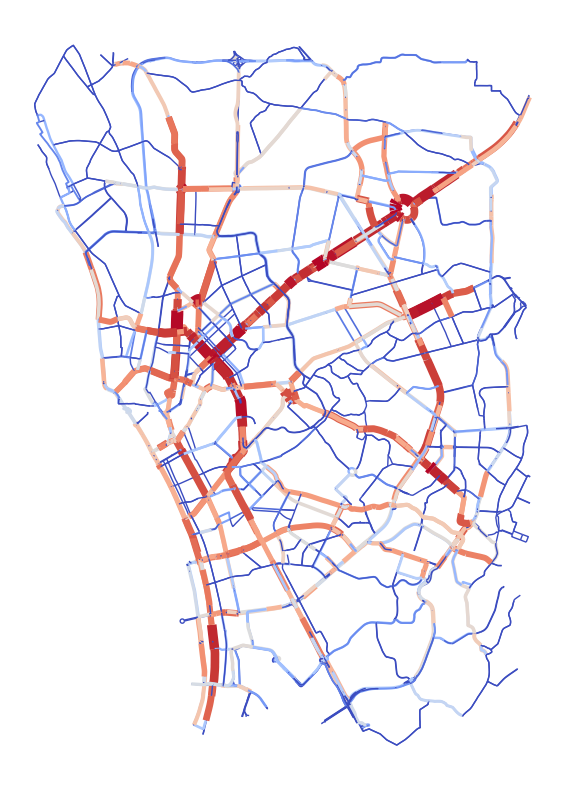

In [12]:
fig, ax = plt.subplots(figsize=(10, 10))

edges_flows.plot(ax=ax, column='flow', cmap='coolwarm', legend=False, linewidth=1+edges_flows['flow'] / 2000)
# cx.add_basemap(ax, crs=edges_flows.crs.to_string(), source=cx.providers.CartoDB.Positron, zoom = 12)


ax.axis('off')


# Network analysis

## Network criticality

In [13]:
edge_centrality = pd.DataFrame(columns=['from', 'to', 'betweenness', 'Traffic_betweenness'])

centrality = nx.edge_betweenness_centrality(Assigned_graph, weight='TT')

for u,v, data in Assigned_graph.edges(data=True):
    Assigned_graph.edges[(u,v)]['betweenness'] = centrality[(u,v)]

    link_demand_ratio =  Assigned_graph.edges[(u,v)]['flow']*5/odDemands.Demand.sum()
    Assigned_graph.edges[(u,v)]['Traffic_betweenness'] = centrality[(u,v)]*link_demand_ratio

    edge_centrality = pd.concat([edge_centrality, pd.DataFrame.from_records([{'from':u,'to':v, 'betweenness': centrality[(u,v)],
                                                                                'Traffic_betweenness': centrality[(u,v)]*link_demand_ratio}])])

C:\Users\raman\AppData\Local\Temp\ipykernel_22256\2359467402.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  edge_centrality = pd.concat([edge_centrality, pd.DataFrame.from_records([{'from':u,'to':v, 'betweenness': centrality[(u,v)],


In [14]:
edges_shape = gpd.read_file(os.path.join(root, city, 'shapefiles/edges.shp')) # for geojson files use edges.geojson
edges_shape = edges_shape.merge(edge_centrality, on=['from', 'to'], how='left')
edge_centrality = gpd.GeoDataFrame(edges_shape, geometry='geometry')

### Visualization example for link criticality

(120.93401844499999, 121.09302245500001, 14.49036297, 14.70779403)

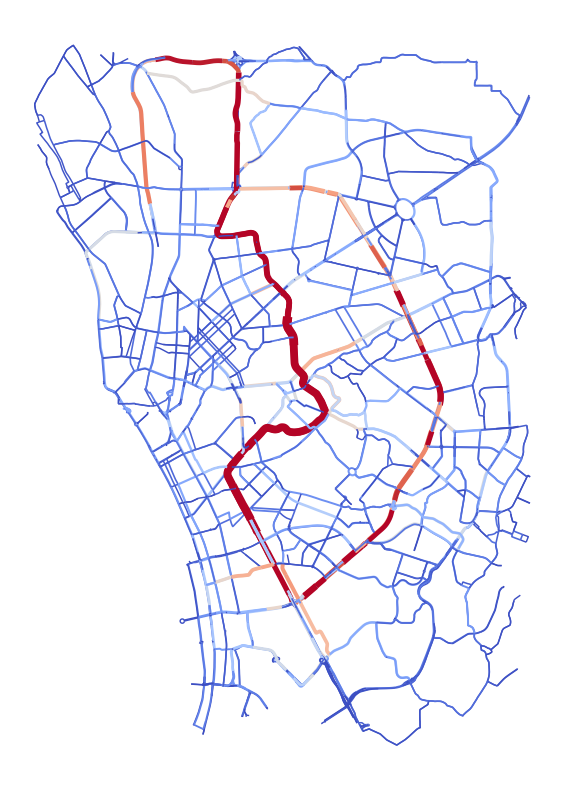

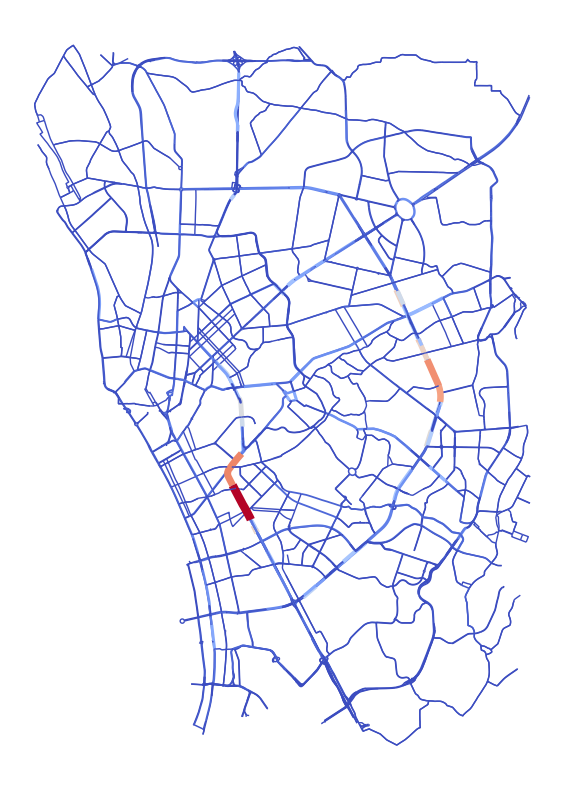

In [15]:
fig, ax = plt.subplots(figsize=(10, 10))

edge_centrality.plot(ax=ax, column='betweenness', cmap='coolwarm', legend=False, vmax = 0.05, linewidth=1+edge_centrality['betweenness'] * 50)
# cx.add_basemap(ax, crs=edge_centrality.crs.to_string(), source=cx.providers.CartoDB.Positron, zoom = 12)
ax.axis('off')

fig, ax = plt.subplots(figsize=(10, 10))

edge_centrality.plot(ax=ax, column='Traffic_betweenness', cmap='coolwarm', legend=False, linewidth=1+edge_centrality['Traffic_betweenness'] * 500)
# cx.add_basemap(ax, crs=edge_centrality.crs.to_string(), source=cx.providers.CartoDB.Positron, zoom = 12)
ax.axis('off')

## Zone accessibility

In [16]:
# OD congestion index
ODCI = {od: EODTT[od] for od in ODdemand if od in EODTT}
# Zone congestion index as origin
ZoneOCI = {zone: [ODCI[od] for od in ODdemand if od in ODCI and od[0] == zone] for zone in list(zone2cent.keys())}
# average zoneOCI
ZoneOCI = {zone: sum(ZoneOCI[zone])/len(ZoneOCI[zone]) for zone in list(zone2cent.keys())}
# Zone congestion index as destination
ZoneDCI = {zone: [ODCI[od] for od in ODdemand if od in ODCI and od[1] == zone] for zone in list(zone2cent.keys())}
# average zoneDCI
ZoneDCI = {zone: sum(ZoneDCI[zone])/len(ZoneDCI[zone]) for zone in list(zone2cent.keys())}

## Emissions analysis

In [17]:
def calculate_emissions(x):
    b0 = 7.613
    b1 = -0.138565
    b2 = 0.0039151
    b3 = -0.000049519
    b4 = 0.0000002386

    x['cost'] = x['cost']*60  # seconds
    x['Speed'] = x['length']/x['cost']    # m/s
    x['Speed'] = x['Speed']*2.23694       # miles/hr
    if x['Speed'] > 100: x['Speed'] = 100
    
    CO2 = math.exp(b0+b1*x['Speed']+b2*x['Speed']**2+b3*x['Speed']**3+b4*x['Speed']**4)

    x['length'] = x['length']*0.000621371 # miles
    CO2 = CO2*x['length']*x['flow']
    CO2 = CO2/1000   # kg
    #x['Speed'] = x['Speed'].apply(lambda x: x/2.23694)  # m/s
    #x['length'] = x['length'].apply(lambda x: x/0.000621371) #  meters
    return CO2

In [18]:
edge_emissions = pd.DataFrame(columns=['from', 'to', 'emissions'])
for u,v, data in Assigned_graph.edges(data=True):
    Assigned_graph.edges[(u,v)]['emissions'] = calculate_emissions(data.copy())
    #edge_emissions = edge_emissions.append({'from':u, 'to':v, 'emissions':G.edges[(u,v)]['emissions']}, ignore_index=True)
    edge_emissions = pd.concat([edge_emissions, pd.DataFrame.from_records([{'from':u,'to':v, 'emissions': data['emissions']}])])

C:\Users\raman\AppData\Local\Temp\ipykernel_22256\1229122251.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  edge_emissions = pd.concat([edge_emissions, pd.DataFrame.from_records([{'from':u,'to':v, 'emissions': data['emissions']}])])


In [19]:
edges_shape = gpd.read_file(os.path.join(root, city, 'shapefiles/edges.shp')) # for geojson files use edges.geojson
zones_shape = gpd.read_file(os.path.join(root, city, 'shapefiles/aggrid_polygon.shp')) # for geojson files use aggrid_polygon.geojson

if 'fishnetID' in zones_shape.columns:
    zones_shape.rename(columns={'fishnetID': 'ZoneID'}, inplace=True)

In [20]:
# add edge_emissions[emissions] column in edges on from and to
edges_shape = edges_shape.merge(edge_emissions, on=['from', 'to'], how='left')
edge_emissions = gpd.GeoDataFrame(edges_shape, geometry='geometry')


In [21]:
# emissions by zone
edge_emissions_byzone = gpd.sjoin(zones_shape, edge_emissions, how='left')[['ZoneID', 'emissions']]
zone_emissions = edge_emissions_byzone.groupby('ZoneID').sum()
zones_shape = zones_shape.merge(zone_emissions, on='ZoneID', how='left')

### Visualization example for zone emissions

(120.93407499999999, 121.09302500000001, 14.493435, 14.708264999999999)

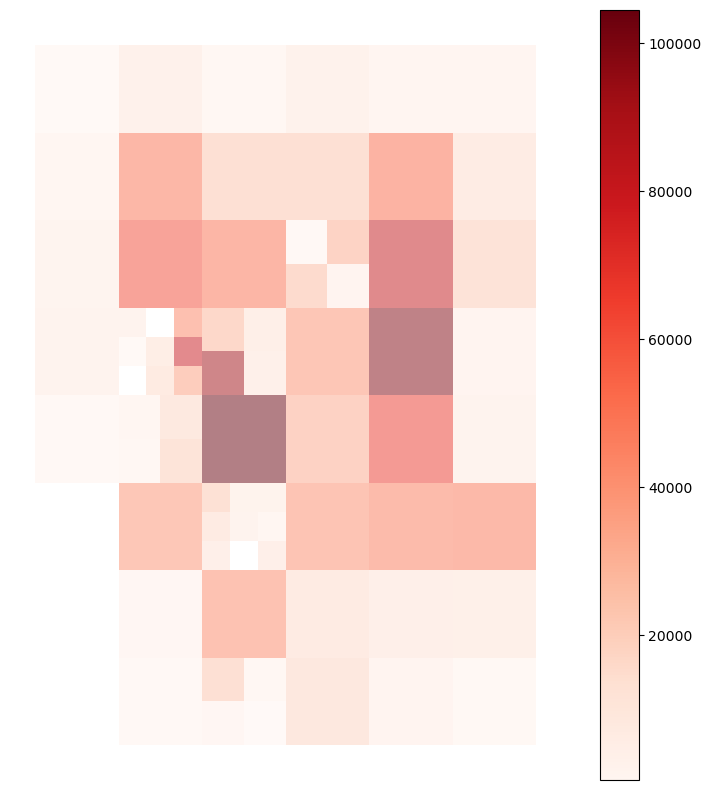

In [22]:
fig, ax = plt.subplots(figsize=(10, 10))

zones_shape.plot(ax=ax, column='emissions', cmap='Reds', legend=True, alpha=0.5)
# cx.add_basemap(ax, crs=zones_shape.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik, zoom = 12)
ax.axis('off')

## Noise analysis

In [23]:
def calculate_noise(data):
    L0 = 37.3  # Base noise level for light vehicles (can be adjusted) default 50
    k = 30   # Speed correction coefficient we can also use the standard formula
    distance = 25  # Reference distance in meters default 15

    flow = data['flow']  # Flow (vehicles per hour)
    speed = (data['length'] / (data['cost'] * 60)) * 3.6  # Convert m/s to km/h
    speed = min(speed, 100)  # Cap at 100 km/h for realistic values
    Lcar= 27.7 + 10 * np.log10(1 + (0.02 * speed)**3)
    Lhg= 23.1 + 12.5 * np.log10(speed) # speed should be for heavy goods vehicle instead
    f2= 10**(0.1 * (Lhg - Lcar)) 
    k2=2
    speedC= Lcar - L0 + 10 * np.log10((100 + (f2-1)) * k2) / (100 + 8.23 * k2)
    if flow == 0:
        return 0  # No noise if no traffic flow
   
    Noiseavg= L0 + 10 * np.log10(flow * (1 + 0.082 * 3))
    Leq= Noiseavg+speedC
    #Leq = L0 + 10 * np.log10(flow) + k * np.log10(speed) - 20 * np.log10(distance / 15)
    #print(data['length'], data['cost'],speed,flow,Leq)
    return Leq

In [24]:
edge_noise = pd.DataFrame(columns=['from', 'to', 'noise'])
for u, v, data in Assigned_graph.edges(data=True):
    Assigned_graph.edges[(u, v)]['noise'] = calculate_noise(data.copy())
    edge_noise = pd.concat([edge_noise, pd.DataFrame.from_records([{'from': u, 'to': v, 'noise': Assigned_graph.edges[(u, v)]['noise']}])])

C:\Users\raman\AppData\Local\Temp\ipykernel_22256\2052158622.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  edge_noise = pd.concat([edge_noise, pd.DataFrame.from_records([{'from': u, 'to': v, 'noise': Assigned_graph.edges[(u, v)]['noise']}])])


In [25]:
edges_shape = edges_shape.merge(edge_noise, on=['from', 'to'], how='left')
edge_noise = gpd.GeoDataFrame(edges_shape, geometry='geometry')

(120.93401844499999, 121.09302245500001, 14.49036297, 14.70779403)

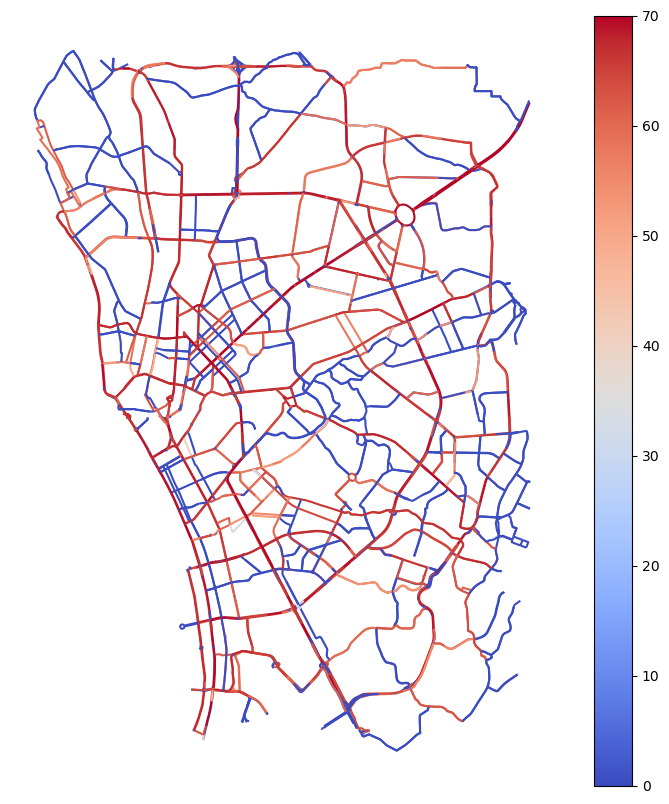

In [26]:
# cell to remove

fig, ax = plt.subplots(figsize=(10, 10))
#edge_noise = edge_noise[edge_noise['noise'] > 60]

edge_noise.plot(ax=ax, column='noise', cmap='coolwarm', legend=True, vmin = 0, vmax = 70)#, linewidth=1+edge_centrality['betweenness'] * 50)
# cx.add_basemap(ax, crs=edge_noise.crs.to_string(), source=cx.providers.CartoDB.Positron, zoom = 12)
ax.axis('off')

## Equity analysis

In [27]:
def gini(x):
    total = 0
    for i, xi in enumerate(x[:-1], 1):
        total += np.sum(np.abs(xi - x[i:]))
    return total / (len(x)**2 * np.mean(x))

### Equity in accessibility

In [28]:
giniOCI = gini(np.array(list(ZoneOCI.values())))
giniDCI = gini(np.array(list(ZoneDCI.values())))

print(f"gini_Origin_CI {giniOCI} \ngini_Destination_CI {giniDCI}")

gini_Origin_CI 0.12885757309184967 
gini_Destination_CI 0.13505269281946428


### Equity in emission exposure

In [29]:
gini_em = gini(zone_emissions['emissions'])

print(f"gini_zone_emissions {gini_em} ")

gini_zone_emissions 0.5222781203943694 
